In [1]:
import h5py
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import pickle
import pandas as pd
import matplotlib.cm as cm
from scipy.signal import savgol_filter
from scipy import stats

batch1 = pickle.load(open(r'D:\논문 준비\코드 복사\코드 복사\코드 복사\batch1.pkl', 'rb'))
#remove batteries that do not reach 80% capacity
del batch1['b1c8']
del batch1['b1c10']
del batch1['b1c12']
del batch1['b1c13']
del batch1['b1c22']

numBat1 = len(batch1.keys())

batch2 = pickle.load(open(r'D:\논문 준비\코드 복사\코드 복사\코드 복사\batch2.pkl','rb'))
# There are four cells from batch1 that carried into batch2, we'll remove the data from batch2
# and put it with the correct cell from batch1
batch2_keys = ['b2c7', 'b2c8', 'b2c9', 'b2c15', 'b2c16']
batch1_keys = ['b1c0', 'b1c1', 'b1c2', 'b1c3', 'b1c4']
add_len = [662, 981, 1060, 208, 482];

for i, bk in enumerate(batch1_keys):
    batch1[bk]['cycle_life'] = batch1[bk]['cycle_life'] + add_len[i]
    for j in batch1[bk]['summary'].keys():
        if j == 'cycle':
            batch1[bk]['summary'][j] = np.hstack((batch1[bk]['summary'][j], batch2[batch2_keys[i]]['summary'][j] + len(batch1[bk]['summary'][j])))
        else:
            batch1[bk]['summary'][j] = np.hstack((batch1[bk]['summary'][j], batch2[batch2_keys[i]]['summary'][j]))
    last_cycle = len(batch1[bk]['cycles'].keys())
    for j, jk in enumerate(batch2[batch2_keys[i]]['cycles'].keys()):
        batch1[bk]['cycles'][str(last_cycle + j)] = batch2[batch2_keys[i]]['cycles'][jk]

del batch2['b2c7']
del batch2['b2c8']
del batch2['b2c9']
del batch2['b2c15']
del batch2['b2c16']

numBat2 = len(batch2.keys())

batch3 = pickle.load(open(r'D:\논문 준비\코드 복사\코드 복사\코드 복사\batch3.pkl','rb'))
# remove noisy channels from batch3
del batch3['b3c37']
del batch3['b3c2']
del batch3['b3c23']
del batch3['b3c32']
del batch3['b3c38']
del batch3['b3c39']

numBat3 = len(batch3.keys())
numBat = numBat1 + numBat2 + numBat3
bat_dict = {**batch1, **batch2, **batch3}

In [2]:
#1. Minimum feature
# train prim_test secondary_test
bat1_2 = {**batch1, **batch2}

prim_test_min=[]
prim_test_cycle=[]
Train_min=[]
Train_cycle=[]
secondary_cycle=[]
secondary_min=[]

for i,j in enumerate(bat1_2.keys()):
    a=len(bat1_2.keys())
    Qdlin10,Qdlin100=bat_dict[j]['cycles']['9']['Qdlin'],bat_dict[j]['cycles']['99']['Qdlin']
    diff=diff=Qdlin100-Qdlin10
    mi,cycle=np.min(diff),bat_dict[j]['cycle_life'].tolist()
    if i==83:
        prim_test_min.append(mi)
        prim_test_cycle.append(cycle)
        break
    if i%2==0:
        prim_test_min.append(mi)
        prim_test_cycle.append(cycle)
    if i%2==1:
        Train_min.append(mi)
        Train_cycle.append(cycle)

for i,j in enumerate(batch3.keys()):
    Qdlin10,Qdlin100=bat_dict[j]['cycles']['9']['Qdlin'],bat_dict[j]['cycles']['99']['Qdlin']
    diff=Qdlin100-Qdlin10
    mi,cycle=np.min(diff),bat_dict[j]['cycle_life'].tolist()
    secondary_min.append(mi)
    secondary_cycle.append(cycle)

In [3]:
#2. Variance
# train prim_test secondary_test
prim_test_var=[]
Train_var=[]
secondary_var=[]
for i,j in enumerate(bat1_2.keys()):
    a=len(bat1_2.keys())
    Qdlin10,Qdlin100=bat_dict[j]['cycles']['9']['Qdlin'],bat_dict[j]['cycles']['99']['Qdlin']
    diff=diff=Qdlin100-Qdlin10
    var=np.var(diff)
    if i==83:
        prim_test_var.append(var)
        break
    if i%2==0:
        prim_test_var.append(var)
    if i%2==1:
        Train_var.append(var)
for i,j in enumerate(batch3.keys()):
    Qdlin10,Qdlin100=bat_dict[j]['cycles']['9']['Qdlin'],bat_dict[j]['cycles']['99']['Qdlin']
    diff=Qdlin100-Qdlin10
    var=np.var(diff)
    secondary_var.append(var)

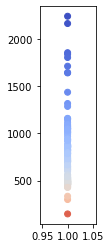

In [4]:
color=[]
cycle_=[]
plt.figure(figsize=(1,4))
for i,j in enumerate(bat_dict.keys()):
    sortcycle=bat_dict[j]['cycle_life']
    cycle_.append(sortcycle.tolist())
    c=(np.log10(sortcycle)-2)/(np.log10(2300)-2)
    color.append(c.tolist())

a=np.array(color).ravel()
b=np.array(cycle_).ravel()
chargecolor=cm.coolwarm_r(a)
plt.scatter(np.ones(len(a)),b,c=cm.coolwarm_r(a))

In [5]:
#3 Slope of the linear fit to the capacity fade curve, cycles 2 to 100
#4 intercept
# train prim_test secondary_test

from sklearn.linear_model import LinearRegression
Train=np.array(range(1,100)).reshape(-1,1)

prim_test_slope=[]
Train_slope=[]
secondary_slope=[]

prim_test_intercept=[]
Train_intercept=[]
secondary_intercept=[]

for i,j in enumerate(bat1_2.keys()):
    QD=bat_dict[j]['summary']['QD']
    QD_reg=[]
    reg = LinearRegression()
    for k in range(1,100):
        QD_1=QD[k].astype(float)
        QD_reg.append(QD_1)
    label=np.array(QD_reg).ravel()
    reg.fit(Train,label)
    if i==83:
        prim_test_slope.append(reg.coef_)
        prim_test_intercept.append(reg.intercept_)
        break
    if i%2==0:
        prim_test_slope.append(reg.coef_)
        prim_test_intercept.append(reg.intercept_)
    if i%2==1:
        Train_slope.append(reg.coef_)
        Train_intercept.append(reg.intercept_)

for i,j in enumerate(batch3.keys()):
    QD=bat_dict[j]['summary']['QD']
    QD_reg=[]
    reg = LinearRegression()
    for k in range(1,100):
        QD_1=QD[k].astype(float)
        QD_reg.append(QD_1)
    label=np.array(QD_reg).ravel()
    reg.fit(Train,label)
    secondary_slope.append(reg.coef_)
    secondary_intercept.append(reg.intercept_)

In [6]:
print(Train_slope)

print(Train_intercept)

[array([5.53529252e-06]), array([1.71363476e-05]), array([1.12284007e-05]), array([-6.428188e-06]), array([2.18094026e-05]), array([2.90493605e-05]), array([1.78862313e-05]), array([-1.03558454e-05]), array([-8.17844416e-05]), array([2.0242585e-06]), array([-1.52104613e-05]), array([-7.72668027e-06]), array([-1.63682189e-05]), array([-1.27762721e-05]), array([-3.1296475e-07]), array([-7.18304391e-06]), array([-9.4371243e-06]), array([-8.20486333e-06]), array([2.11359802e-06]), array([-3.36154607e-05]), array([-0.00035473]), array([-1.27914051e-05]), array([-0.00010675]), array([-0.00021439]), array([-4.1457342e-05]), array([-0.0001212]), array([2.05658961e-05]), array([-0.00017851]), array([-4.39754471e-05]), array([-6.65533568e-05]), array([-3.03303525e-05]), array([4.94572665e-07]), array([3.27914385e-05]), array([1.26573741e-05]), array([2.06875671e-05]), array([-2.80441558e-07]), array([3.50503785e-05]), array([3.18635795e-05]), array([1.66465652e-05]), array([1.25112282e-05]), arr

In [7]:
#5. Discharge Capacity, Cycle2
# train prim_test secondary_test
prim_test_Cycle2=[]
Train_Cycle2=[]
secondary_Cycle2=[]
for i,j in enumerate(bat1_2.keys()):
    a=len(bat1_2.keys())
    Cycle2=np.max(bat_dict[j]['cycles']['1']['Qdlin'])
    if i==83:
        prim_test_Cycle2.append(Cycle2)
        break
    if i%2==0:
        prim_test_Cycle2.append(Cycle2)
    if i%2==1:
        Train_Cycle2.append(Cycle2)
for i,j in enumerate(batch3.keys()):
    Cycle2=np.max(bat_dict[j]['cycles']['1']['Qdlin'])
    secondary_Cycle2.append(Cycle2)

In [8]:
#6 Average charge time, first 5 cycles
# train prim_test secondary_test
#Time-------------->>min
prim_test_AverageT=[]
Train_AverageT=[]
secondary_AverageT=[]

for i,j in enumerate(bat1_2.keys()):
    t1=bat_dict[j]['summary']['chargetime'][1]
    t2=bat_dict[j]['summary']['chargetime'][2]
    t3=bat_dict[j]['summary']['chargetime'][3]
    t4=bat_dict[j]['summary']['chargetime'][4]
    t5=bat_dict[j]['summary']['chargetime'][5]
    ACT=(t1+t2+t3+t4+t5)/5
    if i==83:
        prim_test_AverageT.append(ACT)
        break
    if i%2==0:
        prim_test_AverageT.append(ACT)
    if i%2==1:
        Train_AverageT.append(ACT)    
for i,j in enumerate(batch3.keys()):
    t1=bat_dict[j]['summary']['chargetime'][1]
    t2=bat_dict[j]['summary']['chargetime'][2]
    t3=bat_dict[j]['summary']['chargetime'][3]
    t4=bat_dict[j]['summary']['chargetime'][4]
    t5=bat_dict[j]['summary']['chargetime'][5]
    ACT=(t1+t2+t3+t4+t5)/5
    secondary_AverageT.append(ACT)

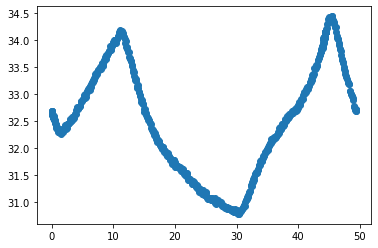

In [9]:
x=bat_dict[j]['cycles']['1']['t']
y=bat_dict[j]['cycles']['1']['T']
plt.scatter(x,y)  

In [10]:
#7  Integral of temperature over time, cycles 2 to 100
# train prim_test secondary_test
prim_test_integralT=[]
Train_integralT=[]
secondary_integralT=[]

from scipy import integrate
for i,j in enumerate(bat1_2.keys()):
    integral=[]
    for k in range(1,100):
        y=bat_dict[j]['cycles']['{}'.format(k)]['T'].tolist()
        x=bat_dict[j]['cycles']['{}'.format(k)]['t'].tolist()
        integral.append(integrate.trapz(y,x))
    intg=sum(integral)
    if i==83:
        prim_test_integralT.append(intg)
        break
    if i%2==0:
        prim_test_integralT.append(intg)
    if i%2==1:
        Train_integralT.append(intg) 
for i,j in enumerate(batch3.keys()):
    integral=[]
    for k in range(1,100):
        y=bat_dict[j]['cycles']['{}'.format(k)]['T'].tolist()
        x=bat_dict[j]['cycles']['{}'.format(k)]['t'].tolist()
        integral.append(integrate.trapz(y,x))
    intg=sum(integral)    
    secondary_integralT.append(intg)         

In [11]:
# 8 Minimum internal resistance, cycles 2  to 100
# train prim_test secondary_test

prim_test_minR=[]
Train_minR=[]
secondary_minR=[]


for i,j in enumerate(bat1_2.keys()):
    a=len(bat_dict[j]['summary']['IR'])
    minIR=[]
    for k in range(1,a):
        IR=bat_dict[j]['summary']['IR'][k]
        if IR==0:
            continue
        minIR.append(IR)
    if i==83:
        prim_test_minR.append(min(minIR))
        break
    if i%2==0:
        prim_test_minR.append(min(minIR))
    if i%2==1:
        Train_minR.append(min(minIR))     
for i,j in enumerate(batch3.keys()):
    a=len(bat_dict[j]['summary']['IR'])
    minIR=[]
    for k in range(1,a):
        IR=bat_dict[j]['summary']['IR'][k]
        if IR==0:
            continue
        minIR.append(IR)
    secondary_minR.append(min(minIR))        

In [12]:
# 9  Internal resistance, difference between cycle 100 and cycle 2
# train prim_test secondary_test

prim_test_R100_2=[]
Train_R100_2=[]
secondary_R100_2=[]

for i,j in enumerate(bat1_2.keys()):
    IR2=bat_dict[j]['summary']['IR'][1]
    IR100=bat_dict[j]['summary']['IR'][99]
    IR100_2=IR100-IR2
    if i==83:
        prim_test_R100_2.append(IR100_2)
        break
    if i%2==0:
        prim_test_R100_2.append(IR100_2)
    if i%2==1:
        Train_R100_2.append(IR100_2)
        
for i,j in enumerate(batch3.keys()):
    IR2=bat_dict[j]['summary']['IR'][1]
    IR100=bat_dict[j]['summary']['IR'][99]
    IR100_2=IR100-IR2
    secondary_R100_2.append(IR100_2)

In [13]:
#Z-score 하는법 Z=(data - train data mean)/traind data std

a=np.array(Train_R100_2)
b=prim_test_R100_2
Z=(b-np.mean(a))/np.std(a)
print(Z)

[  0.32934888   0.52492314   0.39906918  -0.49300401   0.46166008
   0.35191894   0.5216993  -12.15615562  -1.28042985   0.53977764
   0.53302415   0.67046417   0.6256681    0.60285912   0.51409206
   0.67223219   0.78291626   0.86061651   0.56575631   0.97620006
   1.04797189  -2.08464068  -0.49452992  -0.41385749  -1.27670269
  -2.47742022   0.1450071   -0.81854484   0.26100477  -0.5318398
  -0.26112971  -1.26925154   0.29818405  -0.43672699   0.91745738
   0.09562056   0.88603132   0.45526018  -0.92689068   0.27279472
   1.16246914   1.35823134  -2.09515957]


In [14]:
#1. Minimum feature
# train prim_test secondary_test
prim_test_min2=np.log10(np.abs(np.array(prim_test_min))).reshape(-1,1)
prim_test_cycle2=np.array(prim_test_cycle).reshape(-1,1)
Train_min1=np.log10(np.abs(np.array(Train_min))).reshape(-1,1)
Train_cycle1=np.array(Train_cycle).reshape(-1,1)
secondary_cycle3=np.array(secondary_cycle).reshape(-1,1)
secondary_min3=np.log10(np.abs(np.array(secondary_min))).reshape(-1,1)

#2. Variance
# train prim_test secondary_test
prim_test_var2=np.log10(np.abs(np.array(prim_test_var))).reshape(-1,1)
Train_var1=np.log10(np.abs(np.array(Train_var))).reshape(-1,1)
secondary_var3=np.log10(np.abs(np.array(secondary_var))).reshape(-1,1)

#3 Slope of the linear fit to the capacity fade curve, cycles 2 to 100
# train prim_test secondary_test
prim_test_slope2=np.array(prim_test_slope).reshape(-1,1)
Train_slope1=np.array(Train_slope).reshape(-1,1)
secondary_slope3=np.array(secondary_slope).reshape(-1,1)

#4 intercept
prim_test_intercept2=np.array(prim_test_intercept).reshape(-1,1)
Train_intercept1=np.array(Train_intercept).reshape(-1,1)
secondary_intercept3=np.array(secondary_intercept).reshape(-1,1)

#5. Discharge Capacity, Cycle2
# train prim_test secondary_test
prim_test_Cycle22=np.array(prim_test_Cycle2).reshape(-1,1)
Train_Cycle21=np.array(Train_Cycle2).reshape(-1,1)
secondary_Cycle23=np.array(secondary_Cycle2).reshape(-1,1)

#6 Average charge time, first 5 cycles
# train prim_test secondary_test
#Time-------------->>min
prim_test_AverageT2=np.array(prim_test_AverageT).reshape(-1,1)
Train_AverageT1=np.array(Train_AverageT).reshape(-1,1)
secondary_AverageT3=np.array(secondary_AverageT).reshape(-1,1)

#7  Integral of temperature over time, cycles 2 to 100
# train prim_test secondary_test
prim_test_integralT2=np.array(prim_test_integralT).reshape(-1,1)
Train_integralT1=np.array(Train_integralT).reshape(-1,1)
secondary_integralT3=np.array(secondary_integralT).reshape(-1,1)

# 8 Minimum internal resistance, cycles 2  to 100
# train prim_test secondary_test
prim_test_minR2=np.array(prim_test_minR).reshape(-1,1)
Train_minR1=np.array(Train_minR).reshape(-1,1)
secondary_minR3=np.array(secondary_minR).reshape(-1,1)

# 9  Internal resistance, difference between cycle 100 and cycle 2
# train prim_test secondary_test
prim_test_R100_22=np.array(prim_test_R100_2).reshape(-1,1)
Train_R100_21=np.array(Train_R100_2).reshape(-1,1)
secondary_R100_23=np.array(secondary_R100_2).reshape(-1,1)

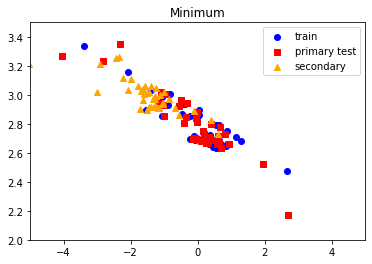

In [15]:
#표준점수를 만들어야됨 Z-score 하는법 Z=(data - train data mean)/traind data std

#1. Min Q100-10(V) 
cycle1=np.log10(Train_cycle1)
cycle2=np.log10(prim_test_cycle2)
cycle3=np.log10(secondary_cycle3)

def Z_score(Train,prim_test,secondary):
    Z1=(Train-np.mean(Train))/np.std(Train)
    Z2=(prim_test-np.mean(Train))/np.std(Train)
    Z3=(secondary-np.mean(Train))/np.std(Train)
    return Z1, Z2, Z3

Z1_1,Z1_2,Z1_3= Z_score(Train_min1,prim_test_min2,secondary_min3)

plt.scatter(Z1_1,cycle1,color='blue',marker='o',label='train')
plt.scatter(Z1_2,cycle2,color='red',marker='s',label='primary test')
plt.scatter(Z1_3,cycle3,color='orange',marker='^',label='secondary')
plt.axis([-5,5,2,3.5])
plt.title('Minimum')
plt.legend()
plt.show()

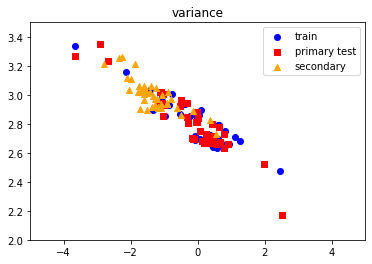

In [16]:
#2. Variance Q100-10(V)

Z2_1,Z2_2,Z2_3= Z_score(Train_var1,prim_test_var2,secondary_var3)

plt.scatter(Z2_1,cycle1,color='blue',marker='o',label='train')
plt.scatter(Z2_2,cycle2,color='red',marker='s',label='primary test')
plt.scatter(Z2_3,cycle3,color='orange',marker='^',label='secondary')
plt.axis([-5,5,2,3.5])
plt.title('variance')
plt.legend()
plt.show()

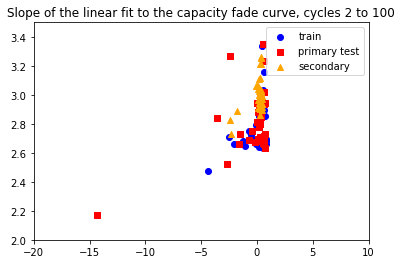

In [17]:
#3. Slope of the linear fit to the capacity fade curve, cycles 2 to 100

Z3_1,Z3_2,Z3_3= Z_score(Train_slope1,prim_test_slope2,secondary_slope3)

plt.scatter(Z3_1,cycle1,color='blue',marker='o',label='train')
plt.scatter(Z3_2,cycle2,color='red',marker='s',label='primary test')
plt.scatter(Z3_3,cycle3,color='orange',marker='^',label='secondary')
plt.axis([-20,10,2,3.5])
plt.title('Slope of the linear fit to the capacity fade curve, cycles 2 to 100')
plt.legend()
plt.show()

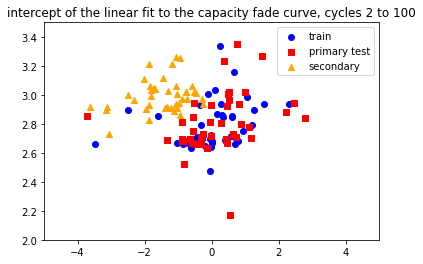

In [18]:
#4. intercept of the linear fit to the capacity fade curve, cycles 2 to 100

Z4_1,Z4_2,Z4_3= Z_score(Train_intercept1,prim_test_intercept2,secondary_intercept3)

plt.scatter(Z4_1,cycle1,color='blue',marker='o',label='train')
plt.scatter(Z4_2,cycle2,color='red',marker='s',label='primary test')
plt.scatter(Z4_3,cycle3,color='orange',marker='^',label='secondary')
plt.axis([-5,5,2,3.5])
plt.title('intercept of the linear fit to the capacity fade curve, cycles 2 to 100')
plt.legend()
plt.show()

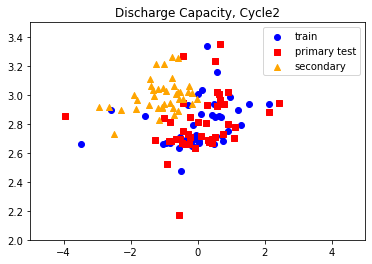

In [19]:
#5. Discharge Capacity, Cycle2

Z5_1,Z5_2,Z5_3= Z_score(Train_Cycle21,prim_test_Cycle22,secondary_Cycle23)

plt.scatter(Z5_1,cycle1,color='blue',marker='o',label='train')
plt.scatter(Z5_2,cycle2,color='red',marker='s',label='primary test')
plt.scatter(Z5_3,cycle3,color='orange',marker='^',label='secondary')
plt.axis([-5,5,2,3.5])
plt.title('Discharge Capacity, Cycle2')
plt.legend()
plt.show()

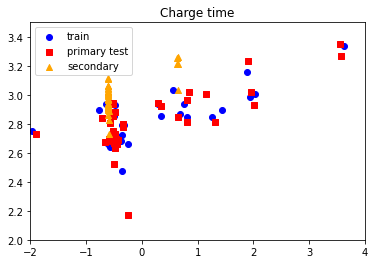

In [20]:
#6 Average charge time, first 5 cycles

Z6_1,Z6_2,Z6_3= Z_score(Train_AverageT1,prim_test_AverageT2,secondary_AverageT3)

plt.scatter(Z6_1,cycle1,color='blue',marker='o',label='train')
plt.scatter(Z6_2,cycle2,color='red',marker='s',label='primary test')
plt.scatter(Z6_3,cycle3,color='orange',marker='^',label='secondary')
plt.axis([-2,4,2,3.5])
plt.title('Charge time')
plt.legend()
plt.show()

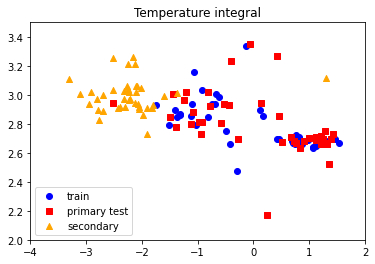

In [21]:
#7 Integral of temperature over time, cycles 2 to 100

Z7_1,Z7_2,Z7_3= Z_score(Train_integralT1,prim_test_integralT2,secondary_integralT3)

plt.scatter(Z7_1,cycle1,color='blue',marker='o',label='train')
plt.scatter(Z7_2,cycle2,color='red',marker='s',label='primary test')
plt.scatter(Z7_3,cycle3,color='orange',marker='^',label='secondary')
plt.axis([-4,2,2,3.5])
plt.title('Temperature integral')
plt.legend()
plt.show()

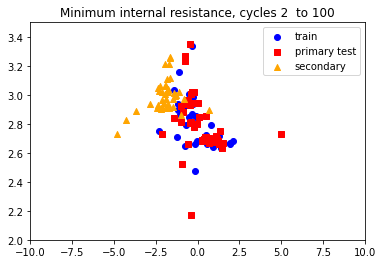

In [22]:
# 8 Minimum internal resistance, cycles 2  to 100

Z8_1,Z8_2,Z8_3= Z_score(Train_minR1,prim_test_minR2,secondary_minR3)

plt.scatter(Z8_1,cycle1,color='blue',marker='o',label='train')
plt.scatter(Z8_2,cycle2,color='red',marker='s',label='primary test')
plt.scatter(Z8_3,cycle3,color='orange',marker='^',label='secondary')
plt.axis([-10,10,2,3.5])
plt.title('Minimum internal resistance, cycles 2  to 100')
plt.legend()
plt.show()

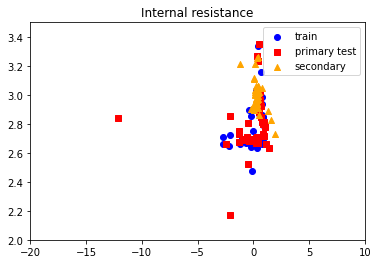

In [23]:
# 9 Internal resistance, difference between cycle 100 and cycle 2

Z9_1,Z9_2,Z9_3= Z_score(Train_R100_21,prim_test_R100_22,secondary_R100_23)

plt.scatter(Z9_1,cycle1,color='blue',marker='o',label='train')
plt.scatter(Z9_2,cycle2,color='red',marker='s',label='primary test')
plt.scatter(Z9_3,cycle3,color='orange',marker='^',label='secondary')
plt.axis([-20,10,2,3.5])
plt.title('Internal resistance')
plt.legend()
plt.show()

In [24]:
# 3, 4  번 검토.

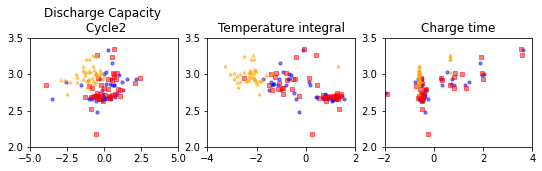

<Figure size 432x288 with 0 Axes>

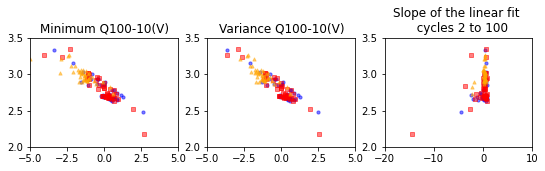

<Figure size 432x288 with 0 Axes>

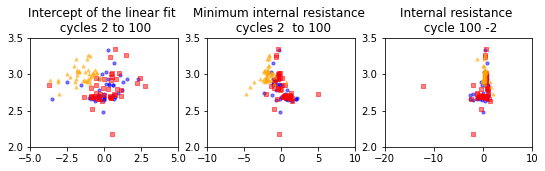

In [25]:
fig=plt.figure(figsize=(9,2))
ax1=fig.add_subplot(1,3,1)
ax1.scatter(Z5_1,cycle1,color='blue',marker='o',alpha=0.5,s=10)
ax1.scatter(Z5_2,cycle2,color='red',marker='s',alpha=0.5,s=10)
ax1.scatter(Z5_3,cycle3,color='orange',marker='^',alpha=0.5,s=10)
ax1.axis([-5,5,2,3.5])
ax1.set_title('Discharge Capacity \n Cycle2')

ax2=fig.add_subplot(1,3,2)
ax2.scatter(Z7_1,cycle1,color='blue',marker='o',alpha=0.5,s=10)
ax2.scatter(Z7_2,cycle2,color='red',marker='s',alpha=0.5,s=10)
ax2.scatter(Z7_3,cycle3,color='orange',marker='^',alpha=0.5,s=10)
ax2.axis([-4,2,2,3.5])
ax2.set_title('Temperature integral')

ax3=fig.add_subplot(1,3,3)
ax3.scatter(Z6_1,cycle1,color='blue',marker='o',alpha=0.5,s=10)
ax3.scatter(Z6_2,cycle2,color='red',marker='s',alpha=0.5,s=10)
ax3.scatter(Z6_3,cycle3,color='orange',marker='^',alpha=0.5,s=10)
ax3.axis([-2,4,2,3.5])
ax3.set_title('Charge time')
plt.show()

plt.clf()
fig=plt.figure(figsize=(9,2))
ax4=fig.add_subplot(1,3,1)
ax4.scatter(Z1_1,cycle1,color='blue',marker='o',alpha=0.5,s=10)
ax4.scatter(Z1_2,cycle2,color='red',marker='s',alpha=0.5,s=10)
ax4.scatter(Z1_3,cycle3,color='orange',marker='^',alpha=0.5,s=10)
ax4.axis([-5,5,2,3.5])
ax4.set_title('Minimum Q100-10(V)')

ax5=fig.add_subplot(1,3,2)
ax5.scatter(Z2_1,cycle1,color='blue',marker='o',alpha=0.5,s=10)
ax5.scatter(Z2_2,cycle2,color='red',marker='s',alpha=0.5,s=10)
ax5.scatter(Z2_3,cycle3,color='orange',marker='^',alpha=0.5,s=10)
ax5.axis([-5,5,2,3.5])
ax5.set_title('Variance Q100-10(V)')

ax6=fig.add_subplot(1,3,3)
ax6.scatter(Z3_1,cycle1,color='blue',marker='o',alpha=0.5,s=10)
ax6.scatter(Z3_2,cycle2,color='red',marker='s',alpha=0.5,s=10)
ax6.scatter(Z3_3,cycle3,color='orange',marker='^',alpha=0.5,s=10)
ax6.axis([-20,10,2,3.5])
ax6.set_title('Slope of the linear fit \n  cycles 2 to 100')
plt.show()

plt.clf()
fig=plt.figure(figsize=(9,2))
ax7=fig.add_subplot(1,3,1)
ax7.scatter(Z4_1,cycle1,color='blue',marker='o',alpha=0.5,s=10)
ax7.scatter(Z4_2,cycle2,color='red',marker='s',alpha=0.5,s=10)
ax7.scatter(Z4_3,cycle3,color='orange',marker='^',alpha=0.5,s=10)
ax7.axis([-5,5,2,3.5])
ax7.set_title('Intercept of the linear fit \n cycles 2 to 100')

ax8=fig.add_subplot(1,3,2)
ax8.scatter(Z8_1,cycle1,color='blue',marker='o',alpha=0.5,s=10)
ax8.scatter(Z8_2,cycle2,color='red',marker='s',alpha=0.5,s=10)
ax8.scatter(Z8_3,cycle3,color='orange',marker='^',alpha=0.5,s=10)
ax8.axis([-10,10,2,3.5])
ax8.set_title('Minimum internal resistance \n cycles 2  to 100')

ax9=fig.add_subplot(1,3,3)
ax9.scatter(Z9_1,cycle1,color='blue',marker='o',alpha=0.5,s=10)
ax9.scatter(Z9_2,cycle2,color='red',marker='s',alpha=0.5,s=10)
ax9.scatter(Z9_3,cycle3,color='orange',marker='^',alpha=0.5,s=10)
ax9.axis([-20,10,2,3.5])
ax9.set_title('Internal resistance \n cycle 100 -2')
plt.show()

In [26]:
# Train data 만들기
Train=np.hstack([Z1_1,Z2_1,Z3_1,Z4_1,Z5_1,Z6_1,Z7_1,Z8_1,Z9_1])
label_=cycle1.ravel()
Train.shape, label_.shape

((41, 9), (41,))

In [27]:
#elasticnet
from sklearn.linear_model import ElasticNetCV
regr=ElasticNetCV(cv=4)
regr.fit(Train,label_)

ElasticNetCV(cv=4)

In [67]:
print('Elastic Net CV alpha:',regr.alpha_)
print('Elastic Net CV coef:',regr.coef_)
print('Elastic Net CV intercept:',regr.intercept_)

Elastic Net CV alpha: 0.00221086095843352
Elastic Net CV coef: [-0.05291441 -0.05189683 -0.          0.          0.0303231   0.03170239
 -0.03087222 -0.0244856  -0.01257664]
Elastic Net CV intercept: 2.793969897643637


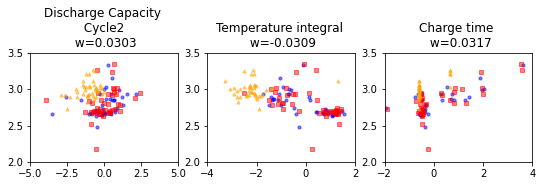

<Figure size 432x288 with 0 Axes>

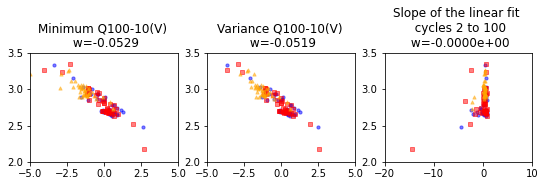

<Figure size 432x288 with 0 Axes>

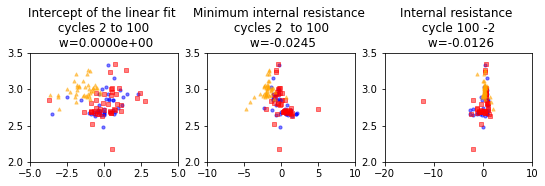

In [29]:
fig=plt.figure(figsize=(9,2))
ax1=fig.add_subplot(1,3,1)
ax1.scatter(Z5_1,cycle1,color='blue',marker='o',alpha=0.5,s=10)
ax1.scatter(Z5_2,cycle2,color='red',marker='s',alpha=0.5,s=10)
ax1.scatter(Z5_3,cycle3,color='orange',marker='^',alpha=0.5,s=10)
ax1.axis([-5,5,2,3.5])
ax1.set_title('Discharge Capacity \n Cycle2 \n w={}'.format(format(regr.coef_[4],"5.4f")))

ax2=fig.add_subplot(1,3,2)
ax2.scatter(Z7_1,cycle1,color='blue',marker='o',alpha=0.5,s=10)
ax2.scatter(Z7_2,cycle2,color='red',marker='s',alpha=0.5,s=10)
ax2.scatter(Z7_3,cycle3,color='orange',marker='^',alpha=0.5,s=10)
ax2.axis([-4,2,2,3.5])
ax2.set_title('Temperature integral \n w={}'.format(format(regr.coef_[6],"5.4f")))

ax3=fig.add_subplot(1,3,3)
ax3.scatter(Z6_1,cycle1,color='blue',marker='o',alpha=0.5,s=10)
ax3.scatter(Z6_2,cycle2,color='red',marker='s',alpha=0.5,s=10)
ax3.scatter(Z6_3,cycle3,color='orange',marker='^',alpha=0.5,s=10)
ax3.axis([-2,4,2,3.5])
ax3.set_title('Charge time \n w={}'.format(format(regr.coef_[5],"5.4f")))
plt.show()

plt.clf()
fig=plt.figure(figsize=(9,2))
ax4=fig.add_subplot(1,3,1)
ax4.scatter(Z1_1,cycle1,color='blue',marker='o',alpha=0.5,s=10)
ax4.scatter(Z1_2,cycle2,color='red',marker='s',alpha=0.5,s=10)
ax4.scatter(Z1_3,cycle3,color='orange',marker='^',alpha=0.5,s=10)
ax4.axis([-5,5,2,3.5])
ax4.set_title('Minimum Q100-10(V) \n w={}'.format(format(regr.coef_[0],"5.4f")))

ax5=fig.add_subplot(1,3,2)
ax5.scatter(Z2_1,cycle1,color='blue',marker='o',alpha=0.5,s=10)
ax5.scatter(Z2_2,cycle2,color='red',marker='s',alpha=0.5,s=10)
ax5.scatter(Z2_3,cycle3,color='orange',marker='^',alpha=0.5,s=10)
ax5.axis([-5,5,2,3.5])
ax5.set_title('Variance Q100-10(V) \n w={}'.format(format(regr.coef_[1],"5.4f")))

ax6=fig.add_subplot(1,3,3)
ax6.scatter(Z3_1,cycle1,color='blue',marker='o',alpha=0.5,s=10)
ax6.scatter(Z3_2,cycle2,color='red',marker='s',alpha=0.5,s=10)
ax6.scatter(Z3_3,cycle3,color='orange',marker='^',alpha=0.5,s=10)
ax6.axis([-20,10,2,3.5])
ax6.set_title('Slope of the linear fit \n  cycles 2 to 100 \n w={}'.format(format(regr.coef_[2],"5.4e")))
plt.show()

plt.clf()
fig=plt.figure(figsize=(9,2))
ax7=fig.add_subplot(1,3,1)
ax7.scatter(Z4_1,cycle1,color='blue',marker='o',alpha=0.5,s=10)
ax7.scatter(Z4_2,cycle2,color='red',marker='s',alpha=0.5,s=10)
ax7.scatter(Z4_3,cycle3,color='orange',marker='^',alpha=0.5,s=10)
ax7.axis([-5,5,2,3.5])
ax7.set_title('Intercept of the linear fit \n cycles 2 to 100 \n w={}'.format(format(regr.coef_[3],"5.4e")))

ax8=fig.add_subplot(1,3,2)
ax8.scatter(Z8_1,cycle1,color='blue',marker='o',alpha=0.5,s=10)
ax8.scatter(Z8_2,cycle2,color='red',marker='s',alpha=0.5,s=10)
ax8.scatter(Z8_3,cycle3,color='orange',marker='^',alpha=0.5,s=10)
ax8.axis([-10,10,2,3.5])
ax8.set_title('Minimum internal resistance \n cycles 2  to 100 \n w={}'.format(format(regr.coef_[7],"5.4f")))

ax9=fig.add_subplot(1,3,3)
ax9.scatter(Z9_1,cycle1,color='blue',marker='o',alpha=0.5,s=10)
ax9.scatter(Z9_2,cycle2,color='red',marker='s',alpha=0.5,s=10)
ax9.scatter(Z9_3,cycle3,color='orange',marker='^',alpha=0.5,s=10)
ax9.axis([-20,10,2,3.5])
ax9.set_title('Internal resistance \n cycle 100 -2 \n w={}'.format(format(regr.coef_[8],"5.4f")))
plt.show()

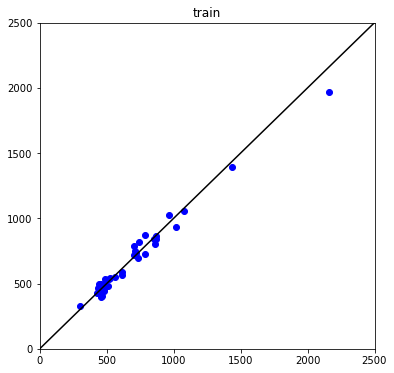

In [30]:
x=[0,2500];y=[0,2500]
plt.figure(figsize=(6,6))
plt.plot(x,y,c='black')
pred=regr.predict(Train)
plt.scatter(10**label_,10**pred,color='blue',marker='o')
plt.title('train')
plt.axis([0,2500,0,2500])
plt.show()

In [31]:
def MAPE(y_test, y_pred):
    return np.mean(np.abs((y_test - y_pred) / y_test)) * 100 
from sklearn.metrics import mean_squared_error
rmse1=np.sqrt(mean_squared_error(10**label_,10**pred))
MAPE1=MAPE(10**label_,10**pred)
print('Train RMSE, Mean Absolute Percentage Error')
rmse1,MAPE(10**label_,10**pred)

Train RMSE, Mean Absolute Percentage Error


(51.16383156291073, 5.726571978803616)

In [32]:
# prim test data 만들기
Train2=np.hstack([Z1_2,Z2_2,Z3_2,Z4_2,Z5_2,Z6_2,Z7_2,Z8_2,Z9_2])
label2=cycle2.ravel()
Train2.shape, label2.shape

((43, 9), (43,))

In [33]:
pred2=regr.predict(Train2)

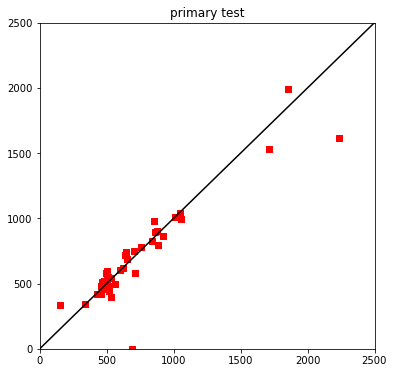

In [34]:
x=[0,2500];y=[0,2500]
plt.figure(figsize=(6,6))
plt.plot(x,y,c='black')
plt.scatter(10**label2,10**pred2,color='red',marker='s')
plt.title('primary test')
plt.axis([0,2500,0,2500])
plt.show()

In [35]:
rmse2=np.sqrt(mean_squared_error(10**label2,10**pred2))
MAPE2=MAPE(10**label2,10**pred2)
print('primary test RMSE, Mean Absolute Percentage Error')
rmse2,MAPE(10**label2,10**pred2)

primary test RMSE, Mean Absolute Percentage Error


(157.7809450713162, 12.461571476001037)

In [36]:
# secondary test data 만들기
Train3=np.hstack([Z1_3,Z2_3,Z3_3,Z4_3,Z5_3,Z6_3,Z7_3,Z8_3,Z9_3])
label3=cycle3.ravel()
Train3.shape, label3.shape

((40, 9), (40,))

In [37]:
pred3=regr.predict(Train3)

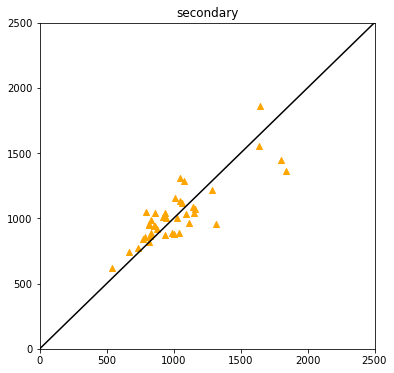

In [38]:
x=[0,2500];y=[0,2500]
plt.figure(figsize=(6,6))
plt.plot(x,y,c='black')
plt.scatter(10**label3,10**pred3,color='orange',marker='^')
plt.title('secondary')
plt.axis([0,2500,0,2500])
plt.show()

In [39]:
rmse3=np.sqrt(mean_squared_error(10**label3,10**pred3))
MAPE3=MAPE(10**label3,10**pred3)
print('secondary test RMSE, Mean Absolute Percentage Error')
rmse3,MAPE(10**label3,10**pred3)

secondary test RMSE, Mean Absolute Percentage Error


(159.64651376698473, 11.947781105782104)

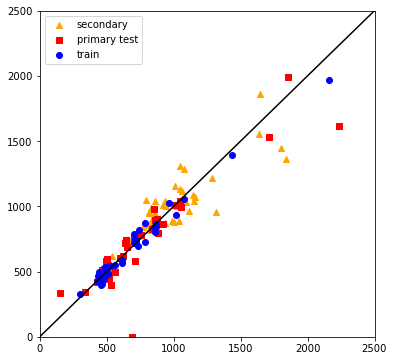

In [40]:
x=[0,2500];y=[0,2500]
plt.figure(figsize=(6,6))
plt.plot(x,y,c='black')
plt.scatter(10**label3,10**pred3,color='orange',marker='^',label='secondary')
plt.scatter(10**label2,10**pred2,color='red',marker='s',label='primary test')
plt.scatter(10**label_,10**pred,color='blue',marker='o',label='train')
plt.axis([0,2500,0,2500])
plt.legend()
plt.show()

In [41]:
# histogram of residuals (predicted – observed) for the primary and secondary test data
s_res=(10**pred3)-(10**label3)
p_res=(10**pred2)-(10**label2)
print(p_res.shape,s_res.shape)

s_res=s_res.reshape(-1,1)
p_res=p_res.reshape(-1,1)
his=np.vstack([p_res,s_res])
print(his,his.shape)

(43,) (40,)
[[ 1.38622445e+02]
 [-6.21346868e+02]
 [-1.77820136e+02]
 [ 8.16786293e+01]
 [-5.61814497e+01]
 [-8.31275655e+01]
 [ 3.22473697e+01]
 [-6.91000000e+02]
 [ 1.21995041e+01]
 [-4.29790106e+00]
 [ 1.24085431e+02]
 [-1.31821460e+01]
 [-5.56721403e+01]
 [ 2.36164702e+01]
 [ 2.43148224e+01]
 [ 5.02058773e+01]
 [ 9.22495052e+01]
 [-5.23865154e+00]
 [-1.25976630e+01]
 [ 3.73217111e+01]
 [ 7.55963685e+00]
 [ 1.85417272e+02]
 [ 6.34706524e+00]
 [ 3.67478175e+01]
 [-6.73021983e+01]
 [ 1.97450708e+01]
 [ 1.06851298e+01]
 [-2.27673287e+01]
 [ 9.14599740e+01]
 [ 3.62449968e+01]
 [ 8.87539728e+01]
 [ 1.55474538e+01]
 [-2.51182826e+01]
 [ 5.73612725e+00]
 [-7.26601284e+01]
 [ 1.35214948e+01]
 [-1.37215603e+02]
 [-2.94596108e+00]
 [ 2.75996653e+01]
 [ 4.36084644e+01]
 [-3.47252816e+01]
 [-1.24810698e+01]
 [-1.32473864e+02]
 [ 1.48963009e+02]
 [ 5.49559821e+01]
 [-1.50417690e+02]
 [ 8.16333049e+01]
 [ 5.60128965e+01]
 [ 7.68580884e+01]
 [-4.75411047e+02]
 [ 1.60495276e+02]
 [-1.54478408e+02]


(0.0, 30.0)

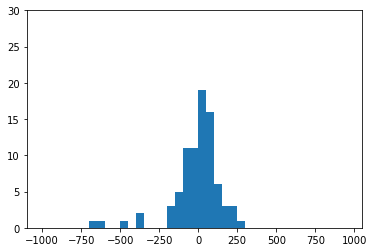

In [42]:
bins=np.arange(-1000,1000,50)# width 조절
plt.hist(his,bins)
plt.ylim(0,30)

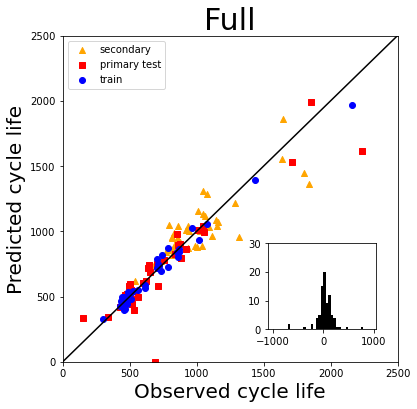

In [66]:
x=[0,2500];y=[0,2500]
plt.figure(figsize=(6,6))
plt.plot(x,y,c='black')
plt.scatter(10**label3,10**pred3,color='orange',marker='^',label='secondary')
plt.scatter(10**label2,10**pred2,color='red',marker='s',label='primary test')
plt.scatter(10**label_,10**pred,color='blue',marker='o',label='train')
plt.xlabel('Observed cycle life',size=20)
plt.ylabel('Predicted cycle life',size=20)
plt.axis([0,2500,0,2500])
plt.title('Full',size=30)
plt.legend()
ax_sub=plt.axes([0.6,0.2,0.25,0.2])
plt.ylim(0,30)
ax_sub.hist(his,bins,color='black')
plt.show()

In [44]:
#해야될것.
#데이터가 어떻게 생긴것인지 설명, 어떻게 만들었는지 설명 , 각 공식에 대한 이론 
#다른사람이 내가 만든것을 보고 만들 수 있도록 설명하기.

In [45]:
'''
1. Data 의 구성. 
  1.1. raw data
      supplementary table 9 
      Dataset, Batch data, Cycle life, Charging policy
''' 


'\n1. Data 의 구성. \n  1.1. raw data\n      supplementary table 9 \n      Dataset, Batch data, Cycle life, Charging policy\n'

In [46]:
Batch_data=[]
Dataset=[]
Cycle_life=[]
Charging_policy=[]
num=[]
for i in range(124):
    if i<=40:
        Batch_data.append('2017-05-12')
        if i%2==0:
            Dataset.append('Prim. Test')
        else:
            Dataset.append('Train')
    elif i<=83:
        Batch_data.append('2017-06-30')
        if i==83:
            Dataset.append('Prim. Test')
        elif i%2==0:
            Dataset.append('Prim. Test')
        else:
            Dataset.append('Train')        
    else:
        Batch_data.append('2018-04-12')
        Dataset.append('Sec. test')
for i,j in enumerate(bat_dict.keys()):
    Cycle_life.append(bat_dict[j]['cycle_life'].tolist())
    Charging_policy.append(bat_dict[j]['charge_policy'])
    num.append(j)
    
CL=np.array(Cycle_life).ravel()
dict_data={'Cell':num,'Dataset':Dataset,'Batch_data':Batch_data,'Cycle_life':CL,'Charging_policy':Charging_policy}  
df=pd.DataFrame(dict_data)
print(df.head())

   Cell     Dataset  Batch_data  Cycle_life Charging_policy
0  b1c0  Prim. Test  2017-05-12      1852.0  3.6C(80%)-3.6C
1  b1c1       Train  2017-05-12      2160.0  3.6C(80%)-3.6C
2  b1c2  Prim. Test  2017-05-12      2237.0  3.6C(80%)-3.6C
3  b1c3       Train  2017-05-12      1434.0      4C(80%)-4C
4  b1c4  Prim. Test  2017-05-12      1709.0      4C(80%)-4C


In [47]:
#df.to_csv('D:\ML\논문\data1.csv')

In [48]:
print('             RMSE(cycles)')
print('Train        Primary test       Secondary test')
print(round(rmse1,1),'          ',round(rmse2,1),'             ',round(rmse3,1))

             RMSE(cycles)
Train        Primary test       Secondary test
51.2            157.8               159.6


In [49]:
print('         Mean percent error(%)')
print('Train        Primary test       Secondary test')
print(round(MAPE1,1),'          ',round(MAPE2,1),'               ',round(MAPE3,1))

         Mean percent error(%)
Train        Primary test       Secondary test
5.7            12.5                 11.9


In [50]:
Train.shape, label_.shape

((41, 9), (41,))

C:\Users\JanggoonKim\anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  # Remove the CWD from sys.path while we load stuff.
C:\Users\JanggoonKim\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
C:\Users\JanggoonKim\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01538558306364351, tolerance: 0.00010703521221153377
  positive)


<function matplotlib.pyplot.show(close=None, block=None)>

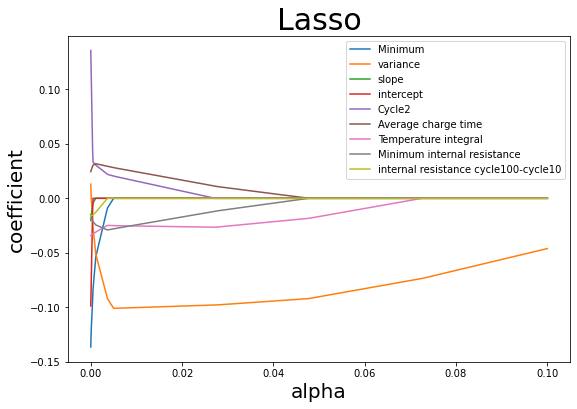

In [51]:
Y=[]
X=[]

plt.figure(figsize=(9,6))
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
for i in np.linspace(0,0.1,1000):
    regrplot=Lasso(alpha=i)
    regrplot.fit(Train,label_)
    Y.append(regrplot.coef_)
    X.append(i)
Y_=np.array(Y)    
plt.plot(X,Y_[:,0],label='Minimum')
plt.plot(X,Y_[:,1],label='variance')
plt.plot(X,Y_[:,2],label='slope')
plt.plot(X,Y_[:,3],label='intercept')
plt.plot(X,Y_[:,4],label='Cycle2')
plt.plot(X,Y_[:,5],label='Average charge time')
plt.plot(X,Y_[:,6],label='Temperature integral')
plt.plot(X,Y_[:,7],label='Minimum internal resistance')
plt.plot(X,Y_[:,8],label='internal resistance cycle100-cycle10')
plt.title('Lasso',size=30)
plt.xlabel('alpha',size=20)
plt.ylabel('coefficient',size=20)
plt.legend()
plt.show


<function matplotlib.pyplot.show(close=None, block=None)>

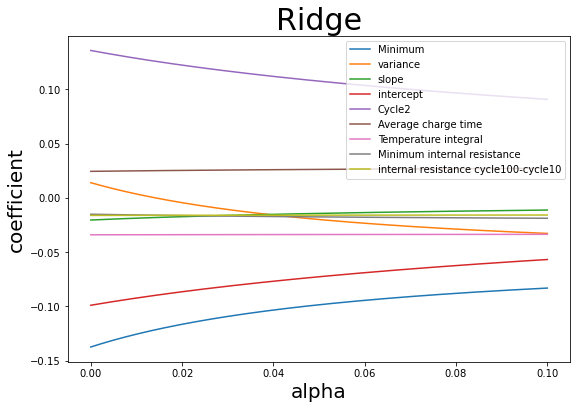

In [52]:
Y=[]
X=[]

plt.figure(figsize=(9,6))
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
for i in np.linspace(0,0.1,1000):
    regrplot=Ridge(alpha=i)
    regrplot.fit(Train,label_)
    Y.append(regrplot.coef_)
    X.append(i)
Y_=np.array(Y)    
plt.plot(X,Y_[:,0],label='Minimum')
plt.plot(X,Y_[:,1],label='variance')
plt.plot(X,Y_[:,2],label='slope')
plt.plot(X,Y_[:,3],label='intercept')
plt.plot(X,Y_[:,4],label='Cycle2')
plt.plot(X,Y_[:,5],label='Average charge time')
plt.plot(X,Y_[:,6],label='Temperature integral')
plt.plot(X,Y_[:,7],label='Minimum internal resistance')
plt.plot(X,Y_[:,8],label='internal resistance cycle100-cycle10')
plt.title('Ridge',size=30)
plt.xlabel('alpha',size=20)
plt.ylabel('coefficient',size=20)
plt.legend()
plt.show

C:\Users\JanggoonKim\anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  # Remove the CWD from sys.path while we load stuff.
C:\Users\JanggoonKim\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
C:\Users\JanggoonKim\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01538558306364351, tolerance: 0.00010703521221153377
  positive)


<function matplotlib.pyplot.show(close=None, block=None)>

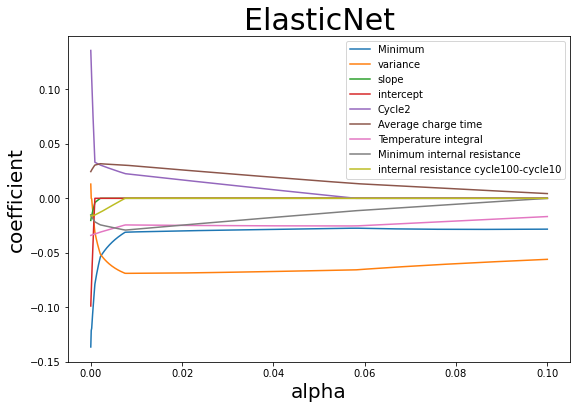

In [53]:
Y=[]
X=[]

plt.figure(figsize=(9,6))
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
for i in np.linspace(0,0.1,1000):
    regrplot=ElasticNet(alpha=i)
    regrplot.fit(Train,label_)
    Y.append(regrplot.coef_)
    X.append(i)
Y_=np.array(Y)    
plt.plot(X,Y_[:,0],label='Minimum')
plt.plot(X,Y_[:,1],label='variance')
plt.plot(X,Y_[:,2],label='slope')
plt.plot(X,Y_[:,3],label='intercept')
plt.plot(X,Y_[:,4],label='Cycle2')
plt.plot(X,Y_[:,5],label='Average charge time')
plt.plot(X,Y_[:,6],label='Temperature integral')
plt.plot(X,Y_[:,7],label='Minimum internal resistance')
plt.plot(X,Y_[:,8],label='internal resistance cycle100-cycle10')
plt.title('ElasticNet',size=30)
plt.xlabel('alpha',size=20)
plt.ylabel('coefficient',size=20)
plt.legend()
plt.show

In [54]:
from sklearn.linear_model import LassoCV
reg = LassoCV(cv=4).fit(Train,label_)
print('Lasso CV alpha:',reg.alpha_)
print('Lasso CV coefficient:',reg.coef_)
print('Lasso CV intercept:',reg.intercept_)

Lasso CV alpha: 0.0011853168690752964
Lasso CV coefficient: [-0.05212981 -0.0526611  -0.          0.          0.03015685  0.03162285
 -0.03075471 -0.02456411 -0.01232674]
Lasso CV intercept: 2.793969897643637


In [55]:
Lassocv=reg.predict(Train)
rmseLassocv=np.sqrt(mean_squared_error(10**label_,10**Lassocv))
print('RMSE','           ','MAPE')
print(rmseLassocv,MAPE(10**label_,10**Lassocv))

RMSE             MAPE
51.22828846856873 5.7338336450407015


In [56]:
Lassocv2=reg.predict(Train2)
rmseLassocv2=np.sqrt(mean_squared_error(10**label2,10**Lassocv2))
print('RMSE','           ','MAPE')
print(rmseLassocv2,MAPE(10**label2,10**Lassocv2))

RMSE             MAPE
157.69415598649326 12.448713517571072


In [57]:
Lassocv3=reg.predict(Train3)
rmseLassocv3=np.sqrt(mean_squared_error(10**label3,10**Lassocv3))
print('RMSE','           ','MAPE')
print(rmseLassocv3,MAPE(10**label3,10**Lassocv3))

RMSE             MAPE
159.19448525072866 11.941988761504478


In [58]:
from sklearn.linear_model import RidgeCV
reg = RidgeCV(cv=4).fit(Train,label_)
print('Ridge CV alpha:',reg.alpha_)
print('Ridge CV coefficient:',reg.coef_)
print('Ridge CV intercept:',reg.intercept_)

Ridge CV alpha: 0.1
Ridge CV coefficient: [-0.0831714  -0.03278303 -0.01123504 -0.05684097  0.09084366  0.02731391
 -0.03363021 -0.01881517 -0.01581988]
Ridge CV intercept: 2.793969897643638


In [60]:
Ridgecv=reg.predict(Train)
rmseRidgecv=np.sqrt(mean_squared_error(10**label_,10**Ridgecv))
print('RMSE','           ','MAPE')
print(rmseRidgecv,MAPE(10**label_,10**Ridgecv))

RMSE             MAPE
44.47419346670861 5.374101958669795


In [61]:
Ridgecv2=reg.predict(Train2)
rmseRidgecv2=np.sqrt(mean_squared_error(10**label2,10**Ridgecv2))
print('RMSE','           ','MAPE')
print(rmseRidgecv2,MAPE(10**label2,10**Ridgecv2))

RMSE             MAPE
162.6221361392523 13.393974119086588


In [62]:
Ridgecv3=reg.predict(Train3)
rmseRidgecv3=np.sqrt(mean_squared_error(10**label3,10**Ridgecv3))
print('RMSE','           ','MAPE')
print(rmseRidgecv3,MAPE(10**label3,10**Ridgecv3))

RMSE             MAPE
212.49620200507263 15.464088070534032


(array([ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  0.,  1.,  0.,  2.,
         0.,  0.,  0.,  2.,  6., 11., 10., 20., 16.,  6.,  3.,  3.,  1.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([-1000,  -950,  -900,  -850,  -800,  -750,  -700,  -650,  -600,
         -550,  -500,  -450,  -400,  -350,  -300,  -250,  -200,  -150,
         -100,   -50,     0,    50,   100,   150,   200,   250,   300,
          350,   400,   450,   500,   550,   600,   650,   700,   750,
          800,   850,   900,   950]),
 <BarContainer object of 39 artists>)

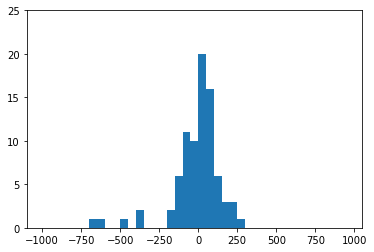

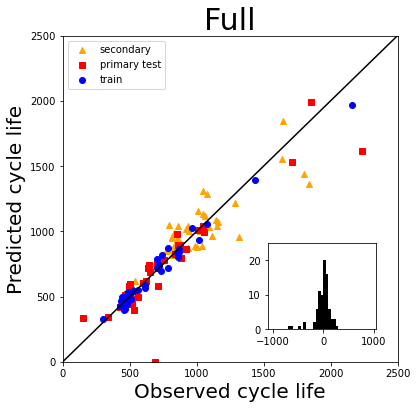

In [63]:
#2 Lasso 
s_res=(10**Lassocv3)-(10**label3)
p_res=(10**Lassocv2)-(10**label2)

s_res=s_res.reshape(-1,1)
p_res=p_res.reshape(-1,1)
his=np.vstack([p_res,s_res])

bins=np.arange(-1000,1000,50)# width 조절
plt.hist(his,bins)
plt.ylim(0,25)

x=[0,2500];y=[0,2500]
plt.figure(figsize=(6,6))
plt.plot(x,y,c='black')
plt.scatter(10**label3,10**Lassocv3,color='orange',marker='^',label='secondary')
plt.scatter(10**label2,10**Lassocv2,color='r',marker='s',label='primary test')
plt.scatter(10**label_,10**Lassocv,color='b',marker='o',label='train')
plt.axis([0,2500,0,2500])
plt.xlabel('Observed cycle life',size=20)
plt.ylabel('Predicted cycle life',size=20)
plt.title('Full',size=30)
plt.legend()
ax_sub=plt.axes([0.6,0.2,0.25,0.2])
plt.ylim(0,25)
ax_sub.hist(his,bins,color='black')

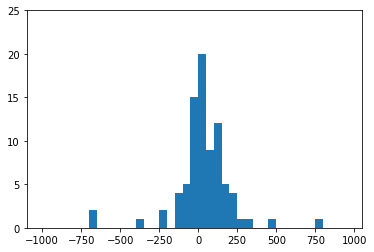

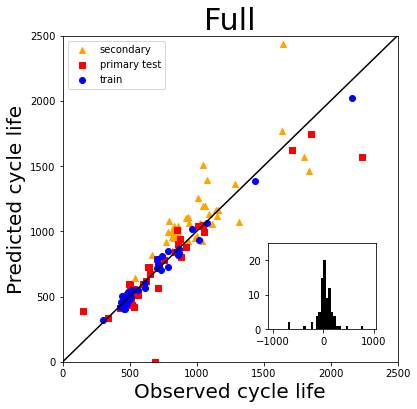

In [65]:
#2 Ridge
s_res=(10**Ridgecv3)-(10**label3)
p_res=(10**Ridgecv2)-(10**label2)


s_res=s_res.reshape(-1,1)
p_res=p_res.reshape(-1,1)
his=np.vstack([p_res,s_res])


bins=np.arange(-1000,1000,50)# width 조절
plt.hist(his,bins)
plt.ylim(0,25)

x=[0,2500];y=[0,2500]
plt.figure(figsize=(6,6))
plt.plot(x,y,c='black')
plt.scatter(10**label3,10**Ridgecv3,color='orange',marker='^',label='secondary')
plt.scatter(10**label2,10**Ridgecv2,color='red',marker='s',label='primary test')
plt.scatter(10**label_,10**Ridgecv,color='blue',marker='o',label='train')
plt.xlabel('Observed cycle life',size=20)
plt.ylabel('Predicted cycle life',size=20)
plt.axis([0,2500,0,2500])
plt.title('Full',size=30)
plt.legend()
ax_sub=plt.axes([0.6,0.2,0.25,0.2])
plt.ylim(0,25)
ax_sub.hist(his,bins,color='black')
plt.show()